In [1]:
exp_str = 'landau-zener m-sweep'

from qiskit import IBMQ, transpile #, schedule, pulse
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.opflow import Y, Z, PauliTrotterEvolution, Suzuki
from qiskit_research import utils

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
IBMQ.load_account()
try:
    provider = IBMQ.get_provider(hub='ibm-q-internal', group='mission-critical', project='bronn')
    backend = provider.get_backend('ibm_lagos')
except:
    provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
    backend = provider.get_backend('ibmq_bogota') # checking gate directions

## Define the System Hamiltonian

The Landau-Zener Hamiltonian is

$$ H = mZ + gY $$

which we can immediately write in `qiskit opflow`.

In [3]:
mm = Parameter('m')
gg = Parameter('g')
ham_lz = mm*Z + gg*Y

In [4]:
from sea.utils import build_resonance_ham

cc = Parameter('c')
ww = Parameter('ω')
h_res = build_resonance_ham(ham_lz, cc, ww)


## Trotterize Unitary Evolution Operator

In [5]:
tt = Parameter('t')
U_ham = (tt*h_res).exp_i()
trot_op = PauliTrotterEvolution(trotter_mode=
                Suzuki(order=2, reps=1)).convert(U_ham)
trot_circ = transpile(trot_op.to_circuit(), 
                basis_gates=['rx', 'ry', 'rz', 'cx'])

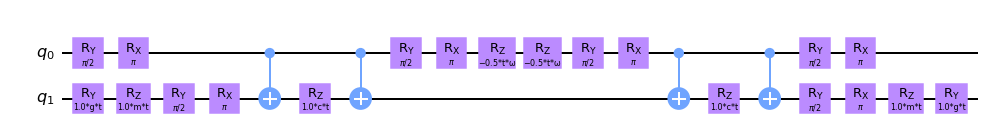

In [6]:
trot_circ.draw('mpl')

In [7]:
from mapomatic import evaluate_layouts, matching_layouts
# from sea.utils import get_avg_gate_error

best_layout = evaluate_layouts(trot_circ, 
                             matching_layouts(trot_circ, backend), backend)[0]
my_layout = best_layout[0]
my_score = best_layout[1]

# avg_gate_error = get_avg_gate_error(backend, my_layout)
# print('Avg 2-qubit gate error is '+str(avg_gate_error)+' for layout '+str(my_layout))
print('Score is '+str((1-my_score)**30)+' for layout '+str(my_layout))

Score is 0.570610105420266 for layout [5, 6]


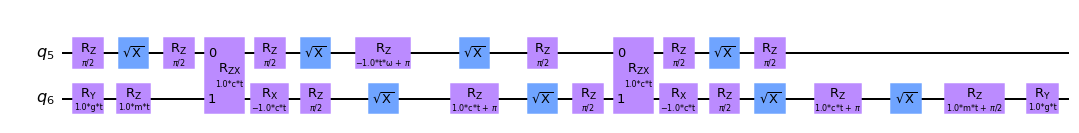

In [8]:
from qiskit_research.utils.convenience import scale_cr_pulses

trot_circ_t = scale_cr_pulses(transpile(trot_circ, initial_layout=my_layout), backend, unroll_rzx_to_ecr=False)

trot_circ_t.draw('mpl', idle_wires=False)

## Build Sweep Experiment

In [9]:
Nt = 30 # number of Trotter steps

c_set = 0.1
g_set = 1.5
t_set = 10
dt_set = t_set/Nt
m_range = np.linspace(-3, 3, 16)
w_range = np.linspace(-8, 8, 51)

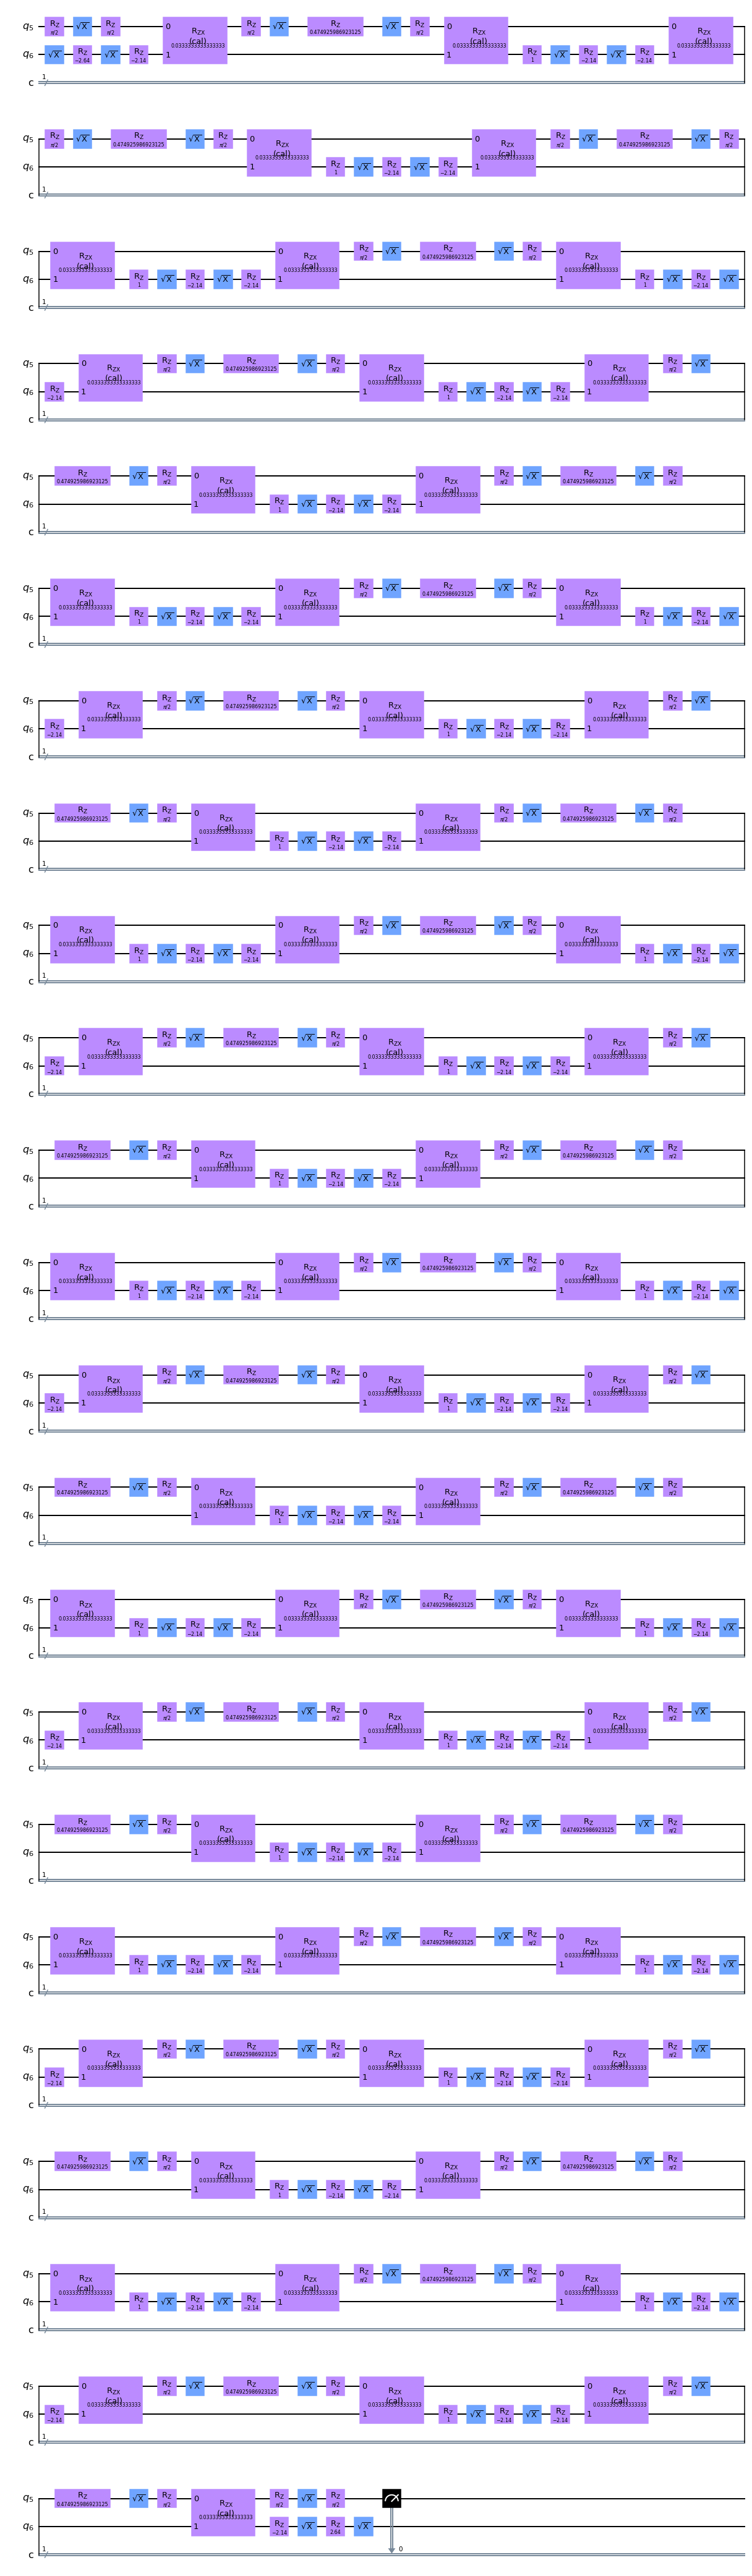

In [10]:
from qiskit_research.utils.convenience import attach_cr_pulses
from sea.utils import stringify

qr = QuantumRegister(trot_circ_t.num_qubits, 'q')
cr = ClassicalRegister(1, 'c')

param_bind = {
    cc: c_set,
    gg: g_set,
    tt: dt_set
}
circs = []
for m_set in m_range:
    for w_set in w_range:
        param_bind[mm] = m_set
        param_bind[ww] = w_set
        metadata_circ = {
            'experiment': exp_str,
            'backend': str(backend),
            'layout': my_layout,
            'trotter': Nt,
            **param_bind,
        }
        circ = QuantumCircuit(qr, cr, metadata=stringify(metadata_circ))
        for _ in range(Nt):
            circ.append(trot_circ_t.to_instruction(), qr)
            
        circ = circ.decompose()
        circ.measure(my_layout[0], 0)
        circs.append(attach_cr_pulses(circ, backend, param_bind))
        
circs[-1].draw('mpl', idle_wires=False)

In [11]:
from qiskit import schedule
trot_sched = schedule(circs[-1], backend)

In [12]:
trot_sched.duration*(1/4.5)

16099.555555555555

In [13]:
from copy import deepcopy
from sea.utils import cost_func
from mapomatic import deflate_circuit

trot_circ_t = transpile(trot_circ, backend, initial_layout=my_layout)

qr = QuantumRegister(trot_circ_t.num_qubits, 'q')
cr = ClassicalRegister(1, 'c')
trot_circs = QuantumCircuit(qr, cr)

for _ in range(Nt):
    trot_circs.append(trot_circ_t.to_instruction(), qr)
trot_circs = trot_circs.decompose()
trot_circs.measure(my_layout[0], 0)

evaluate_layouts(deflate_circuit(trot_circs), my_layout, backend, cost_function=cost_func)

[([5, 6], 0.6536277425504265)]

In [14]:

evaluate_layouts(deflate_circuit(circs[-1]), my_layout, backend, cost_function=cost_func)
# print('Score is '+str((1-my_score)**30)+' for layout '+str(my_layout))

Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an RZX gate
Found an R

[([5, 6], 0.06017943726463992)]

In [ ]:
metadata_exp = stringify({
    'experiment': exp_str+' from [%.1f, %.1f]: g=%.1f, c=%.1f' % (m_range[0], m_range[-1], g_set, c_set),
    'type': exp_str.split(' ')[1],
    'backend': str(backend),
    'layout': my_layout,
    'trotter': Nt,
    'dt': dt_set,
    cc: c_set,
    gg: g_set,
    tt: t_set,
    mm: list(m_range),
    ww: list(w_range),
})

In [ ]:
from qiskit.tools.monitor import job_monitor
from datetime import datetime
import json

job = backend.run(circs, job_name=metadata_exp['experiment'], 
                  header=metadata_exp, shots=8192)

metadata_exp['time'] = str(datetime.now())
with open("experiments.json", "a") as outfile:
    json.dump({job.job_id(): metadata_exp}, outfile)
    
print(job.job_id())
job_monitor(job)

In [ ]:
open?